In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Show plots inline
%matplotlib inline

# Nice style
sns.set(style="whitegrid")


In [2]:
# Load raw data
df = pd.read_csv("../data/raw/customer_intelligence_dataset.csv")

# Quick peek
df.head()


,sale_id,customer_id,product_id,product_name,category,price,quantity,sale_date,total_value,age,gender,region,segment,churn,tenure_months,last_purchase_date,feedback_text,sentiment
0,S000001,CUST01553,P004,Desk,Furniture,12000,2,2020-01-07,24000,40,Female,West,Small Business,1,37,2023-04-04,"Terrible experience, will not buy again.",Negative
1,S000002,CUST00161,P010,Projector,Electronics,45000,2,2023-11-10,90000,50,Female,West,Corporate,0,44,2023-03-02,Excellent customer service.,Positive
2,S000003,CUST00627,P010,Projector,Electronics,45000,4,2022-07-04,180000,33,Male,South,Corporate,0,25,2023-11-04,Product quality could be better.,Neutral
3,S000004,CUST01291,P009,Monitor,Electronics,12000,1,2023-10-18,12000,41,Male,West,Consumer,0,56,2023-08-18,"Delivery was late, not happy.",Positive
4,S000005,CUST01456,P004,Desk,Furniture,12000,4,2023-09-13,48000,60,Female,West,Consumer,0,52,2023-05-14,"Delivery was late, not happy.",Positive


In [3]:
# Shape
print("Rows:", df.shape[0], "Columns:", df.shape[1])

Rows: 8000 Columns: 18


In [4]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sale_id             8000 non-null   object
 1   customer_id         8000 non-null   object
 2   product_id          8000 non-null   object
 3   product_name        8000 non-null   object
 4   category            8000 non-null   object
 5   price               8000 non-null   int64 
 6   quantity            8000 non-null   int64 
 7   sale_date           8000 non-null   object
 8   total_value         8000 non-null   int64 
 9   age                 8000 non-null   int64 
 10  gender              8000 non-null   object
 11  region              8000 non-null   object
 12  segment             8000 non-null   object
 13  churn               8000 non-null   int64 
 14  tenure_months       8000 non-null   int64 
 15  last_purchase_date  8000 non-null   object
 16  feedback_text       8000

In [5]:
# Missing values
df.isnull().sum()

sale_id               0
customer_id           0
product_id            0
product_name          0
category              0
price                 0
quantity              0
sale_date             0
total_value           0
age                   0
gender                0
region                0
segment               0
churn                 0
tenure_months         0
last_purchase_date    0
feedback_text         0
sentiment             0
dtype: int64

In [6]:
# Parse date columns
df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')
df['last_purchase_date'] = pd.to_datetime(df['last_purchase_date'], errors='coerce')

print("NaT in sale_date:", df['sale_date'].isna().sum())
print("NaT in last_purchase_date:", df['last_purchase_date'].isna().sum())


NaT in sale_date: 0
NaT in last_purchase_date: 0


In [7]:
print(df['sale_date'])
print(df['last_purchase_date'] )

0      2020-01-07
1      2023-11-10
2      2022-07-04
3      2023-10-18
4      2023-09-13
          ...    
7995   2022-02-05
7996   2023-01-24
7997   2021-03-09
7998   2023-07-13
7999   2020-05-13
Name: sale_date, Length: 8000, dtype: datetime64[ns]
0      2023-04-04
1      2023-03-02
2      2023-11-04
3      2023-08-18
4      2023-05-14
          ...    
7995   2023-01-27
7996   2023-07-24
7997   2023-03-12
7998   2023-11-09
7999   2023-09-15
Name: last_purchase_date, Length: 8000, dtype: datetime64[ns]


In [8]:
# --- Tidy categorical text fields ---
# Strip whitespace and make text values consistent.
text_cols = ['product_name','category','region','gender','segment','feedback_text','sentiment']
for c in text_cols:
    df[c] = df[c].astype(str).str.strip()

In [9]:
# Optional: normalize capitalization for cleaner grouping later
df['region']    = df['region'].str.title()
df['category']  = df['category'].str.title()
df['sentiment'] = df['sentiment'].str.title()


In [10]:
# Example: clean up inconsistent gender values
gender_map = {'m':'Male','male':'Male','f':'Female','female':'Female'}
df['gender'] = df['gender'].str.lower().map(gender_map).fillna(df['gender'])

In [11]:
# --- Check if any rows are complete duplicates ---
dups = df.duplicated().sum()
print("Exact duplicate rows:", dups)

# If duplicates exist, remove them
if dups:
    df = df.drop_duplicates().reset_index(drop=True)

Exact duplicate rows: 0


In [12]:
# --- Check uniqueness of primary key: sale_id ---
unique_sales = df['sale_id'].nunique()
print("Unique sale_id:", unique_sales, "| total rows:", len(df))

Unique sale_id: 8000 | total rows: 8000


In [13]:
# If sale_id is not unique, see which IDs repeat
dupe_sales = df['sale_id'][df['sale_id'].duplicated()].unique()
dupe_sales[:10]  # show first 10 duplicate IDs if they exist

array([], dtype=object)

In [14]:
# --- Check if total_value matches price * quantity ---
calc_total = df['price'] * df['quantity']
mismatch = (calc_total != df['total_value'])
print("Mismatched total_value rows:", mismatch.sum())

Mismatched total_value rows: 0


In [15]:
# If mismatches exist, fix them but keep original for reference
if mismatch.any():
    df['total_value_original'] = df['total_value']
    df.loc[mismatch, 'total_value'] = calc_total[mismatch]

In [16]:
# Save the cleaned version so we don’t repeat cleaning every time
df.to_csv("../data/processed/cleaned_transactions.csv", index=False)
print("Saved -> ../data/processed/cleaned_transactions.csv")

Saved -> ../data/processed/cleaned_transactions.csv


## Build a customer-level dataset

In [17]:
import numpy as np

# We'll need a reference date (max sale date in the dataset)
max_date = df['sale_date'].max()

# Group by customer_id to roll up transactions
customers_df = (
    df.groupby('customer_id').agg(
        age=('age','first'),                           # assume age stays constant
        gender=('gender','first'),
        region=('region','first'),
        tenure_months=('tenure_months','first'),
        last_purchase_date=('last_purchase_date','max'),
        total_spent=('total_value','sum'),             # total money spent
        num_purchases=('sale_id','count'),             # number of transactions
        churn=('churn','first')                        # churn flag (same across rows)
    ).reset_index()
)

# Add some engineered features
customers_df['avg_purchase_value'] = (
    customers_df['total_spent'] / customers_df['num_purchases']
).replace([np.inf, -np.inf], 0)

# Recency = days since last purchase
customers_df['recency_days'] = (max_date - customers_df['last_purchase_date']).dt.days

# Save this customer-level dataset
customers_df.to_csv("../data/processed/customers.csv", index=False)
print("Saved -> ../data/processed/customers.csv")
customers_df.head(8000)


Saved -> ../data/processed/customers.csv


,customer_id,age,gender,region,tenure_months,last_purchase_date,total_spent,num_purchases,churn,avg_purchase_value,recency_days
0,CUST00001,43,Female,South,50,2023-07-18,249000,2,0,124500.000000,166
1,CUST00002,22,Male,East,37,2023-06-27,84300,4,1,21075.000000,187
2,CUST00003,59,Female,North,18,2023-02-06,130150,4,0,32537.500000,328
3,CUST00004,29,Male,East,3,2023-11-28,349000,5,0,69800.000000,33
4,CUST00005,53,Female,West,45,2023-04-05,8000,1,0,8000.000000,270
...,...,...,...,...,...,...,...,...,...,...,...
1962,CUST01995,48,Male,West,31,2023-10-05,300,1,0,300.000000,87
1963,CUST01997,53,Male,West,19,2023-12-31,120500,5,1,24100.000000,0
1964,CUST01998,46,Female,East,54,2023-07-10,3000,1,0,3000.000000,174
1965,CUST01999,53,Male,East,31,2023-04-04,45300,3,0,15100.000000,271


##  --- EDA checks ---



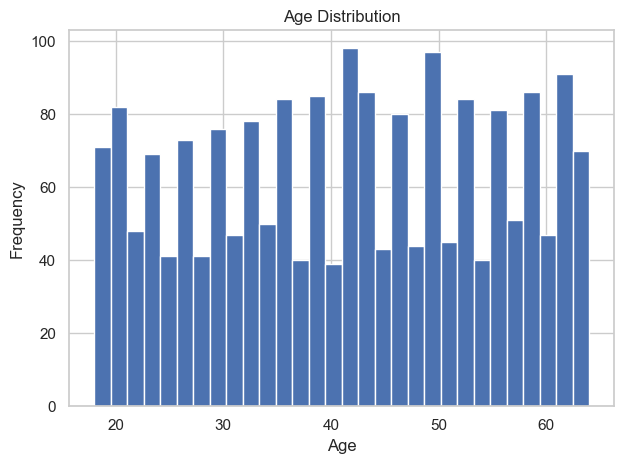

In [18]:
# --- Age distribution histogram ---
ax = customers_df['age'].plot(kind='hist', bins=30, title='Age Distribution')
ax.set_xlabel("Age")
ax.figure.tight_layout()


In [19]:
# --- Churn rate overall ---
overall_churn = customers_df['churn'].mean()
print(f"Overall churn rate: {overall_churn:.2%}")


Overall churn rate: 25.01%


Churn rate by segment:
 segment
Corporate         0.259513
Small Business    0.257009
Consumer          0.225845
Name: churn, dtype: float64


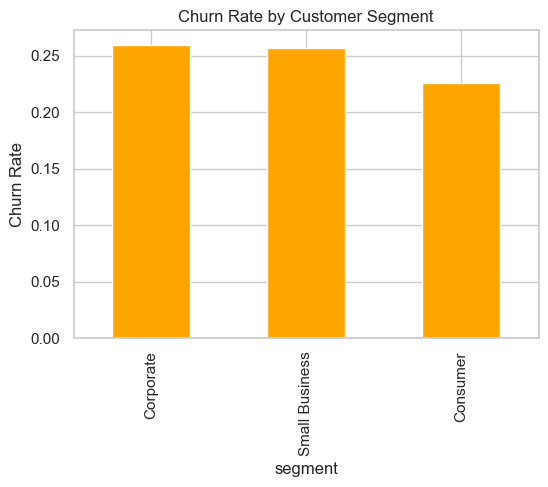

In [20]:
# ---  Churn by Segment ---
churn_by_segment = df.groupby('segment')['churn'].mean().sort_values(ascending=False)
print("Churn rate by segment:\n", churn_by_segment)

churn_by_segment.plot(kind='bar', color='orange', figsize=(6,4))
plt.title("Churn Rate by Customer Segment")
plt.ylabel("Churn Rate")
plt.show()


In [21]:
# --- Churn by region ---
churn_by_region = customers_df.groupby('region')['churn'].mean().sort_values(ascending=False)
churn_by_region


region
West     0.268994
East     0.249042
South    0.242972
North    0.239130
Name: churn, dtype: float64

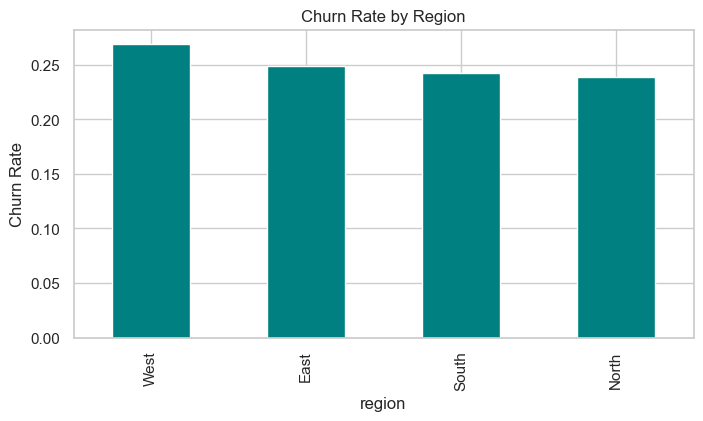

In [22]:
churn_by_region.plot(kind='bar', color='teal', figsize=(8,4))
plt.title("Churn Rate by Region")
plt.ylabel("Churn Rate")
plt.show()

Churn rate by gender:
 gender
Female    0.254843
Male      0.241491
Name: churn, dtype: float64


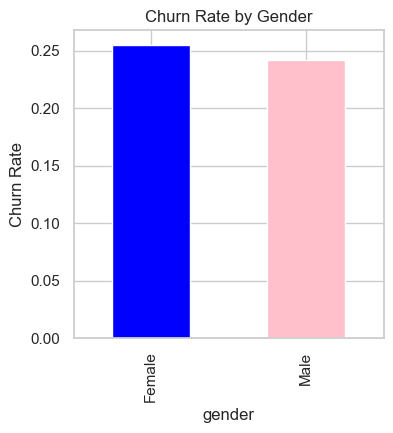

In [23]:
# --- Churn by Gender ---
churn_by_gender = df.groupby('gender')['churn'].mean()
print("Churn rate by gender:\n", churn_by_gender)

churn_by_gender.plot(kind='bar', color=['blue','pink'], figsize=(4,4))
plt.title("Churn Rate by Gender")
plt.ylabel("Churn Rate")
plt.show()

In [24]:
# --- Churn rate by age group ---
age_bins = [18, 25, 35, 45, 55, 65, 100]  # You can adjust depending on dataset
age_labels = ['18-24','25-34','35-44','45-54','55-64','65+']

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

churn_by_age = df.groupby('age_group')['churn'].mean().sort_values(ascending=False)

print("Churn rate by age group:")
print(churn_by_age)

Churn rate by age group:
age_group
18-24    0.285583
35-44    0.278127
45-54    0.241589
25-34    0.237485
55-64    0.210650
65+           NaN
Name: churn, dtype: float64


C:\Users\miracle.adeoye\AppData\Local\Temp\ipykernel_5188\1938858329.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_age = df.groupby('age_group')['churn'].mean().sort_values(ascending=False)


In [25]:
# --- Top categories by sales ---
cat_sales = df.groupby('category')['total_value'].sum().sort_values(ascending=False).head(10)
cat_sales


category
Electronics        414586000
Furniture           47464000
Office Supplies       363650
Name: total_value, dtype: int64

Top 10 products by revenue:
 product_name
Laptop          175840000
Projector       108450000
Smartphone       59325000
Printer          35400000
Monitor          28596000
Desk             28200000
Office Chair     19264000
Headphones        6975000
Notebook           241800
Pen Pack           121850
Name: total_value, dtype: int64


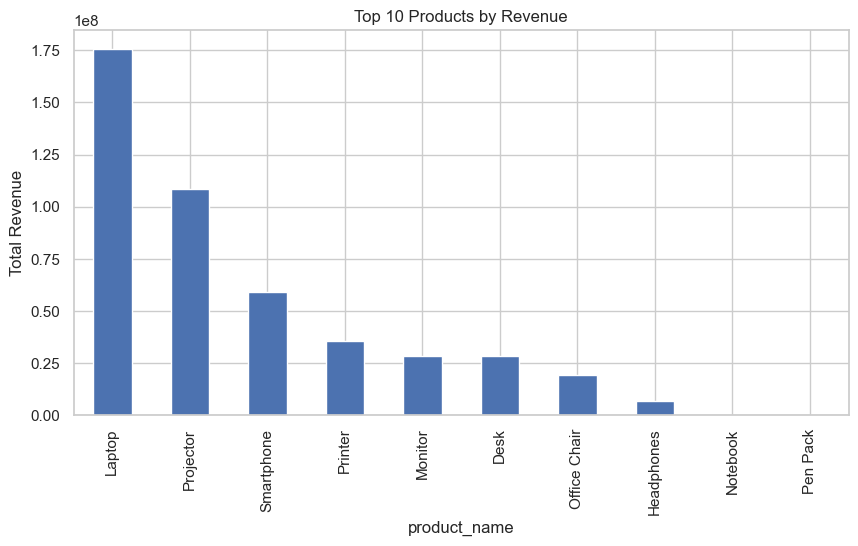

In [26]:
# ---  Top Products by Revenue ---
top_products = df.groupby('product_name')['total_value'].sum().sort_values(ascending=False).head(10)
print("Top 10 products by revenue:\n", top_products)

top_products.plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Products by Revenue")
plt.ylabel("Total Revenue")
plt.show()

In [27]:
# --- Customer Lifetime Value (CLV) Approximation ---
avg_revenue = df.groupby('customer_id')['total_value'].sum().mean()
avg_tenure = df['tenure_months'].mean()
clv = avg_revenue * avg_tenure
print(f"Estimated Customer Lifetime Value (CLV): {clv:.2f}")


Estimated Customer Lifetime Value (CLV): 6987012.66


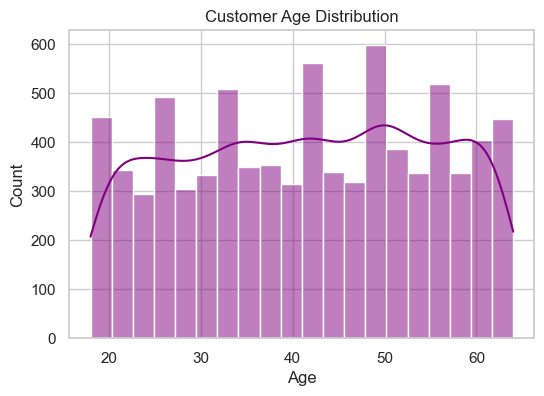

In [28]:
# ---  Age Distribution of Customers ---
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=20, kde=True, color='purple')
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

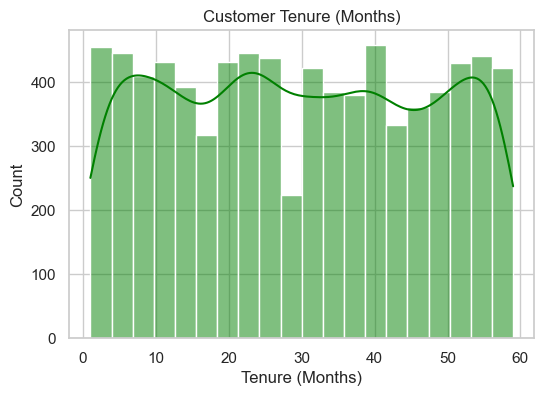

In [29]:
# --- 7. Tenure Distribution ---
plt.figure(figsize=(6,4))
sns.histplot(df['tenure_months'], bins=20, kde=True, color='green')
plt.title("Customer Tenure (Months)")
plt.xlabel("Tenure (Months)")
plt.ylabel("Count")
plt.show()


Sentiment distribution:
 sentiment
Positive    3926
Neutral     2444
Negative    1630
Name: count, dtype: int64


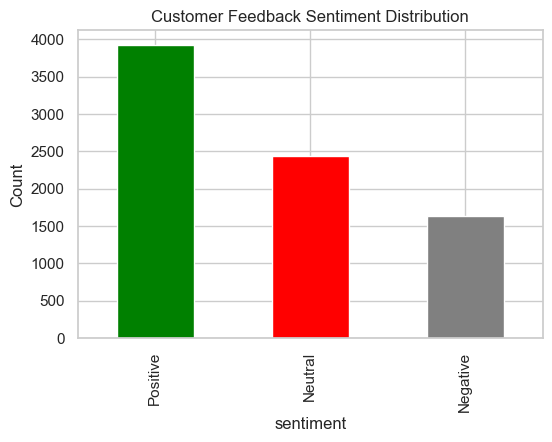

In [30]:

# --- Sentiment Breakdown ---
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment distribution:\n", sentiment_counts)

sentiment_counts.plot(kind='bar', color=['green','red','gray'], figsize=(6,4))
plt.title("Customer Feedback Sentiment Distribution")
plt.ylabel("Count")
plt.show()


In [31]:
# --- Average sales per region ---
# Group by region and calculate average total_value
avg_sales_region = df.groupby('region')['total_value'].mean().sort_values(ascending=False)

print("Average sales by region:")
print(avg_sales_region)


Average sales by region:
region
North    59363.155109
South    58093.500253
West     57156.431113
East     56760.083064
Name: total_value, dtype: float64


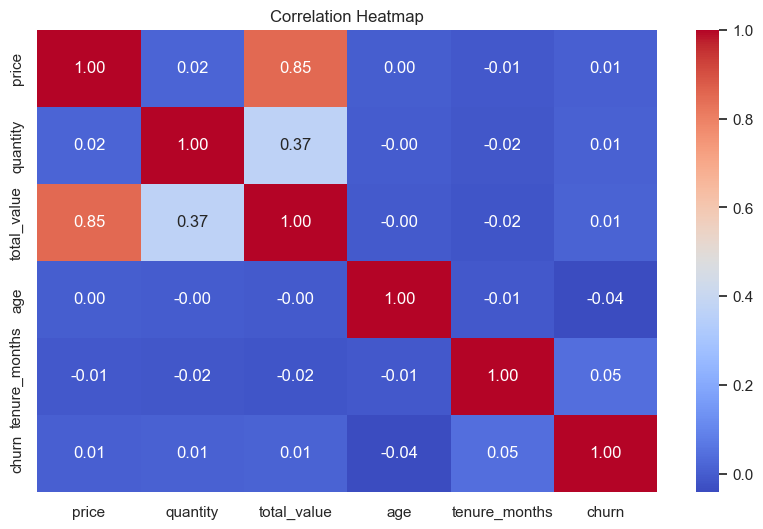

In [32]:
# --- Correlation heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(df[['price','quantity','total_value','age','tenure_months','churn']].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


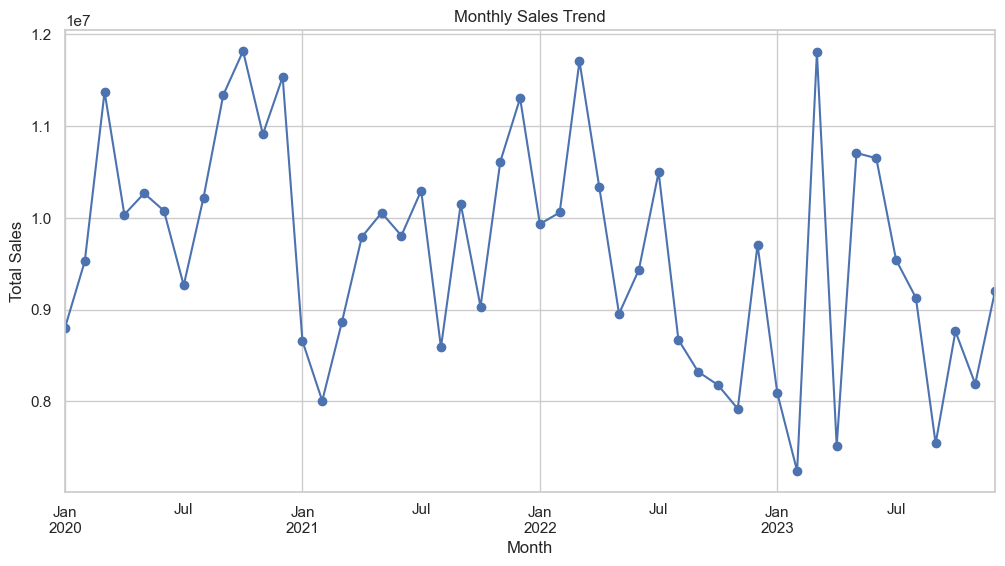

In [33]:
# --- Monthly sales trend ---
# Convert sale_date to datetime (if not already)
df['sale_date'] = pd.to_datetime(df['sale_date'])

monthly_sales = df.groupby(df['sale_date'].dt.to_period('M'))['total_value'].sum()

monthly_sales.plot(kind='line', figsize=(12,6), marker='o')
plt.title("Monthly Sales Trend")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.show()


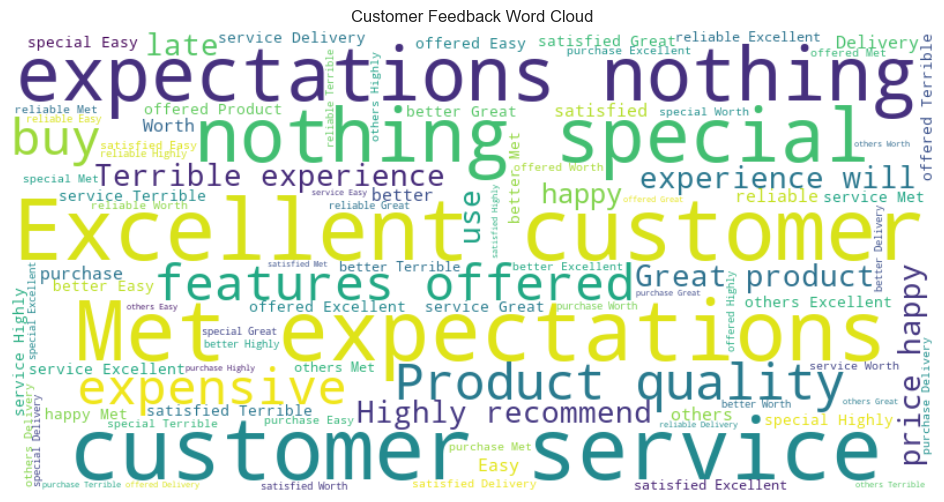

In [34]:
from wordcloud import WordCloud

# --- Feedback word cloud ---
text = " ".join(feedback for feedback in df.feedback_text.dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Customer Feedback Word Cloud")
plt.show()
